# Алгоритмы интеллектуальной обработки больших объемов данных
## Семестровый проект


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,7)

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда, необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить, как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные, необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

In [2]:
# Загрузка данных целиком
df_list = []
for chunk in range(1,3):
    filepath = '/media/ivan/Acer/Ivan/sphere/Hearthstone/trainingData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))

df_data = pd.concat(df_list)

In [3]:
df_data.shape

(1000000, 45)

In [4]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [5]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [6]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.50461

Визуализируем коэффициенты корреляции между колонками

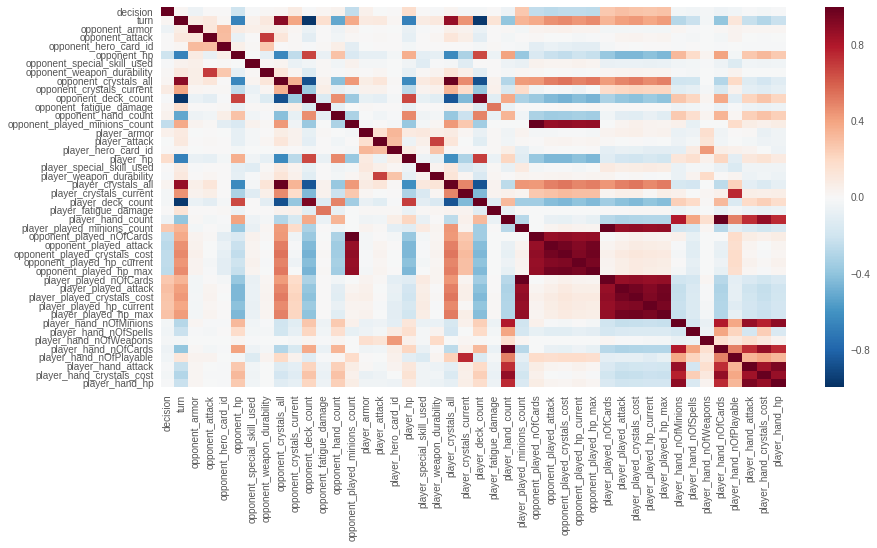

In [7]:
sns.heatmap(df_data.corr())

<h2>Логистическая регрессия</h2>

hero_card_id - категориальная переменная

In [7]:
un_opp = df_data['opponent_hero_card_id'].unique()
print u'Уникальные карты оппонента:', un_opp
print u'Их число:', len(un_opp)
un_pl = df_data['player_hero_card_id'].unique()
print u'Уникальные карты игрока:', un_pl
print u'Их число:', len(un_pl)

Уникальные карты оппонента: [ 798  754  612  390   25 1235  494  981  326]
Их число: 9
Уникальные карты игрока: [ 981  754  612  494   25 1235  326  390  798]
Их число: 9


Векторизуем категориальные признаки - opponent_hero_card_id и player_hero_card_id. Эти поля могут принимать по 9 значений. Создадим для каждого из значений отдельную колонку, в которой для каждой игры будет стоять либо 0, либо 1, в зависимости от того, эта ли карта используется в данной игре:

In [8]:
from sklearn.preprocessing import OneHotEncoder

opponent = OneHotEncoder().fit_transform(df_data['opponent_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)
player = OneHotEncoder().fit_transform(df_data['player_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)

for i in xrange(len(opponent[0])):
    df_data['opponent_hero_card_{}'.format(i)] = opponent[:,i]
    df_data['player_hero_card_{}'.format(i)] = player[:,i]

Удалим ставшие ненужными колонки opponent_hero_card_id и player_hero_card_id:

In [9]:
df_data.drop(df_data[['opponent_hero_card_id', 'player_hero_card_id']], axis=1, inplace=True)

Теперь наши данные выглядят так:

In [10]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1
opponent_deck_count,11,19,22,17,12


Преобразуем dataframe в матрицу признаков:

In [11]:
X = df_data.iloc[:,1:].values
y = df_data.iloc[:,0].values

print X.shape, y.shape

(1000000, 59) (1000000,)


In [12]:
y

array([1, 1, 1, ..., 1, 1, 0])

In [19]:
from sklearn.linear_model import LogisticRegression

In [14]:
del df_data

In [18]:
import gc
gc.collect()

0

Найдем оптимальные параметры модели на части данных. Будем считать, что данные распределены равномерно и для всей выборки параметры будут такими же. 

In [20]:
from sklearn.model_selection import GridSearchCV

In [17]:
estimator = LogisticRegression(random_state=None)
params = {'C': np.logspace(-3, 3, 20)}
grid = GridSearchCV(estimator, params).fit(X[:10000], y[:10000])

In [18]:
grid.best_estimator_

LogisticRegression(C=0.0020691380811147901, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Обучим классификатор с наилучшими параметрами на полной обучающей выборке:

In [16]:
model = LogisticRegression(C=0.002).fit(X[:1000000], y[:1000000])

Очистим память:

In [17]:
del X
del y

Загрузим тестовые данные:

In [30]:
# Загрузка данных
filepath = '/media/ivan/Acer/Ivan/sphere/Hearthstone/testData_tabular.csv'
df_test = pd.read_csv(filepath, sep=',')

In [20]:
df_test.head().T

,0,1,2,3,4
gamestate_id,6845857.0,9279433.0,6642076.0,9169516.0,8991397.0
decision,NaN,NaN,NaN,NaN,NaN
turn,12.0,6.0,14.0,7.0,9.0
opponent.armor,0.0,0.0,0.0,0.0,0.0
opponent.attack,0.0,0.0,0.0,0.0,0.0
opponent.hero_card_id,798.0,326.0,390.0,798.0,326.0
opponent.hp,29.0,12.0,12.0,30.0,30.0
opponent.special_skill_used,1.0,0.0,0.0,0.0,1.0
opponent.weapon_durability,0.0,0.0,0.0,0.0,0.0
opponent.crystals_all,10.0,5.0,10.0,6.0,8.0


Обработаем тестовую выборку так же, ка обучающую:

In [31]:
from sklearn.preprocessing import OneHotEncoder

df_test.columns = df_test.columns.str.replace('.', '_')
df_test = df_test.set_index('gamestate_id')

opponent = OneHotEncoder().fit_transform(df_test['opponent_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)
player = OneHotEncoder().fit_transform(df_test['player_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)

for i in xrange(len(opponent[0])):
    df_test['opponent_hero_card_{}'.format(i)] = opponent[:,i]
    df_test['player_hero_card_{}'.format(i)] = player[:,i]
    
df_test.drop(df_test[['opponent_hero_card_id', 'player_hero_card_id']], axis=1, inplace=True)

In [32]:
X_test = df_test.iloc[:,1:].values
X_test.shape

(750000, 59)

In [24]:
del df_test

Предскажем вероятности классов на тестовой выборке:

In [25]:
scores = model.predict_proba(X_test)
len(scores)

750000

Точность 0.7896

<h2>Random Forest</h2>

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
X = df_data.iloc[:,1:].values
y = df_data.iloc[:,0].values

print X.shape, y.shape 

(1000000, 43) (1000000,)


In [7]:
%%time
model = RandomForestClassifier(n_estimators=100, max_features=10).fit(X, y)

CPU times: user 2min 23s, sys: 228 ms, total: 2min 23s
Wall time: 2min 23s


In [8]:
# Загрузка тестовых данных
filepath = '/media/ivan/Acer/Ivan/sphere/Hearthstone/testData_tabular.csv'
df_test = pd.read_csv(filepath, sep=',')

df_test.columns = df_test.columns.str.replace('.', '_')
df_test = df_test.set_index('gamestate_id')

X_test = df_test.iloc[:,1:].values
#del df_test

In [9]:
df_test.head()

,decision,turn,opponent_armor,opponent_attack,opponent_hero_card_id,opponent_hp,opponent_special_skill_used,opponent_weapon_durability,opponent_crystals_all,opponent_crystals_current,...,player_played_hp_current,player_played_hp_max,player_hand_nOfMinions,player_hand_nOfSpells,player_hand_nOfWeapons,player_hand_nOfCards,player_hand_nOfPlayable,player_hand_attack,player_hand_crystals_cost,player_hand_hp
gamestate_id,,,,,,,,,,,,,,,,,,,,,
6845857.0,NaN,12,0,0,798,29,1,0,10,8,...,3,5,5,0,0,5,5,16,17,20
9279433.0,NaN,6,0,0,326,12,0,0,5,5,...,15,15,3,2,0,5,0,16,28,19
6642076.0,NaN,14,0,0,390,12,0,0,10,0,...,9,19,2,1,0,3,3,7,10,7
9169516.0,NaN,7,0,0,798,30,0,0,6,6,...,7,7,4,2,0,6,6,13,20,15
8991397.0,NaN,9,0,0,326,30,1,0,8,2,...,3,3,2,1,0,3,3,9,15,7


In [12]:
model.feature_importances_

array([ 0.02084075,  0.00866091,  0.0057399 ,  0.04115667,  0.06633621,
        0.00372737,  0.00644015,  0.01349518,  0.02634384,  0.02728891,
        0.00029108,  0.03129505,  0.0161866 ,  0.00902979,  0.00738546,
        0.03482523,  0.06231983,  0.00490962,  0.00670075,  0.01150833,
        0.02135758,  0.02596321,  0.00015468,  0.01431904,  0.01397486,
        0.01272474,  0.03595995,  0.02607384,  0.02970583,  0.03503942,
        0.01634821,  0.04165142,  0.03297969,  0.03349   ,  0.03638303,
        0.01781416,  0.01613269,  0.00725385,  0.01439634,  0.0208491 ,
        0.04580567,  0.04966829,  0.04747274])

In [10]:
scores = model.predict_proba(X_test)
len(scores)

750000

Лучшая точность 0.7569

<h2>Понижение размерности</h2>

In [13]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA(n_components=20, copy=False).fit(X)

In [17]:
X_new = pca.transform(X)

In [18]:
X_new.shape

(1000000, 20)

In [21]:
estimator = LogisticRegression(random_state=None)
params = {'C': np.logspace(-3, 3, 20)}
grid = GridSearchCV(estimator, params).fit(X, y)

In [22]:
grid.best_estimator_

LogisticRegression(C=483.29302385717523, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [23]:
grid.best_score_

0.70063500000000001

In [26]:
model = LogisticRegression(C=483).fit(X, y)

In [33]:
X_test_new = pca.transform(X_test)

In [35]:
scores = model.predict_proba(X_test)

Точность 0.7865

<h2>Запись результатов в файл:</h2>

In [11]:
f = open('/media/ivan/Acer/Ivan/sphere/Hearthstone/hearthstone.txt', 'w')
s = ''
for i in xrange(len(scores)):
    s += str(scores[i, 1]) + '\n'
f.write(s)
f.close()

Результаты на странице конкурса: <br>
i.kozlov<br>
0.7896